In [ ]:
!pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html --user 

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 154.6MB 44kB/s 
     |████████████████████████████████| 5.1MB 59.5MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from pathlib import Path
import time, os
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader
from nnViz_pytorch import *

root = '/data_sources'

In [2]:
dataset = pd.read_csv( index_col = 0,  parse_dates = True, infer_datetime_format = True, filepath_or_buffer = './data_sources/2018-01-01__2019-01-01__NConservatory__allMerged.csv')

dataset.index = pd.to_datetime(dataset.index, utc=True).tz_convert('America/Los_Angeles')

In [3]:
orderedSensorList = ( 'co2_1','co2_2', 'co2_3', 'co2_4',                        
                      'temp_1', 'temp_2', 'temp_3', 'temp_4',                     
                      'dew_1','dew_2', 'dew_3', 'dew_4',
                      'relH_1', 'relH_2', 'relH_3', 'relH_4',
                      'externTemp_1', 
                      'externHumid_1', 
                      'externSunrise_1',                      
                      'externCondition_1' )
orderedDataset = dataset.reindex( index = dataset.index, columns = orderedSensorList )

In [ ]:
dayIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.dayofweek/6, decimals=2), 
                       name='dayIndex')
hourIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.hour/24, decimals=2), 
                       name='hourIndex')

orderedDatasetTimeReference = pd.concat([orderedDataset, hourIndexDF, dayIndexDF], axis=1)

saturdayVal = np.round(5/6,decimals=2)
sundayVal = np.round(6/6,decimals=2)

weekdayData = orderedDatasetTimeReference[ ( dayIndexDF != saturdayVal) &( dayIndexDF != sundayVal) ]

weekendData = orderedDatasetTimeReference[ ( dayIndexDF == saturdayVal) | (dayIndexDF == sundayVal) ]
weekdayData.shape, weekendData.shape

continuousData = weekdayData.values[:, 0:17] # first 17 sensors are continuous valued
categoricalData = weekdayData.values[:, 17:]

standardScaler = StandardScaler()
standardScaler.fit( continuousData )

minMaxScaler = MinMaxScaler()
minMaxScaler.fit( categoricalData )

scaledContinuousData = standardScaler.transform(continuousData)
scaledCategoricalData = minMaxScaler.transform(categoricalData)

weekdayData_scaled =  pd.DataFrame( index = weekdayData.index,
                                    data = np.hstack( (scaledContinuousData, scaledCategoricalData)),
                                    columns = weekdayData.columns)

In [ ]:
def build_train_data ( inputDataframe, outputFilename, advanceTimedeltaStr = '15 min' ):

    npFilename = outputFilename + '.npy'
    npFilenameSamplebounds = outputFilename + '_sampleBounds' + '.npy'
    rebuildFlag = True # flips if file exists in cache and user agrees to restore

    windowCounter = correctLenWindows = fixedWindows = 1
    trimNeededWindows = extensionNeededWindows = 1
    sumExtensionAmount = sumTrimAmount = 0
    
    def extract_one_day( startTime, endTime, idealIndex, nExtensionAttempts=10 ):        
        nonlocal correctLenWindows, trimNeededWindows, extensionNeededWindows, \
                sumExtensionAmount, sumTrimAmount, fixedWindows

        oneDay = inputDataframe[ (inputDataframe.index >= startTime) \
                                         & (inputDataframe.index < endTime)]
        
        if len(oneDay) == len(idealIndex):
            correctLenWindows += 1

        # available data in day range is too long -- trimming required
        if len(oneDay) > len(idealIndex):
            trimNeededWindows += 1
            sumTrimAmount += len(oneDay) - len(idealIndex)
            oneDay = oneDay.iloc[0:len(idealIndex)]
        
        # available data in day range is of insufficient length -- extension required 
        if len(oneDay) < len(idealIndex):
            extensionNeededWindows += 1
            sumExtensionAmount += len(idealIndex) - len(oneDay)
            
            oneDay = None
            # attempt to extend one sample at a time up to nExtensionAttempts
            for iExtensionAttempt in range( nExtensionAttempts ):
                endTime += pd.Timedelta( advanceTimedeltaStr)
                extendedDay = inputDataframe[ (inputDataframe.index >= startTime) \
                                                 & (inputDataframe.index < endTime)]
                # sucessfully extened data slice
                if len( extendedDay) == len( idealIndex ):
                    fixedWindows += 1
                    oneDay = extendedDay
                    break
        
        # only happens when available data requires extension beyond nExtensionAttempts
        if oneDay is None:
            return None, None, None
        
        assert ( len(oneDay) == len(idealIndex) )
        return oneDay.values.reshape(1,-1, order = 'F'), oneDay.index[0], oneDay.index[-1]
    
    
    # check cache
    if Path(npFilename).is_file() and Path(npFilenameSamplebounds).is_file():
        print('created on: {} \n\t size: {} MB'.format( time.ctime(os.path.getctime(npFilename)), 
                                                        Path(npFilename).stat().st_size / 1e6 ))
        if 'y' == input('load from cache? (y/n): '):
            npTrainMatrix = np.load(npFilename, allow_pickle=True) # load from cache
            sampleIndexBounds = np.load(npFilenameSamplebounds, allow_pickle=True)
            rebuildFlag = False
    
    if rebuildFlag:
        npTrainMatrix = None
        sampleIndexBounds = None
        npTestMatrix = None

        startTime = inputDataframe.index[0]
        while(1):
            endTime = startTime + pd.Timedelta('1 day');
            
            # terminate window extraction once end of dataset is reached
            if startTime > inputDataframe.index[-1] or endTime > inputDataframe.index[-1]:
                break
            
            # generate an ideal index [ 96 x 15 min samples from current startTime ]
            idealIndex = pd.date_range(start=startTime, end=endTime, freq='15T', closed='left' );
            
            # ensure that current window is a weekday
            if (idealIndex.dayofweek < 5).all():
                
                # gather data from sensor streams going one day forward
                dataWindow, windowStartIndex, windowEndIndex = \
                    extract_one_day ( startTime, endTime, idealIndex)
                
                # dataWindow is none only when more than ~10 samples are missing                
                if dataWindow is not None:                
                    windowCounter += 1
                    
                    # first iteration is a direct assignment, all others require appending 
                    if npTrainMatrix is None:
                        npTrainMatrix = dataWindow;
                        sampleIndexBounds = np.array([windowStartIndex, windowEndIndex]);
                    else:
                        assert( dataWindow.shape[1] == npTrainMatrix.shape[1] ) # import ipdb; ipdb.set_trace()
                        npTrainMatrix = np.append( npTrainMatrix, dataWindow, axis = 0 );
                        sampleIndexBounds = np.append( sampleIndexBounds, 
                                                       np.array([windowStartIndex, windowEndIndex]) , axis = 0);
                        
            else:
                pass # skipping -- day segment includes a piece of the weekend
            
            avgTrim = np.round(sumTrimAmount/trimNeededWindows, decimals=2);
            avgExtend = np.round(sumExtensionAmount/extensionNeededWindows, decimals=2);
            
            # advance to next sample
            startTime = startTime + pd.Timedelta(advanceTimedeltaStr);

        print('nWindows {} - nCorrect {}; nTrimNeeded {} | avg.trim {}; nExtendNeeded {} | avg.ext {} | fixedViaExtension {}'.format(windowCounter, correctLenWindows, 
                       trimNeededWindows, avgTrim, extensionNeededWindows, avgExtend, fixedWindows), end='\r')

        print('\nwriting to cache')
        
        # save to cache
        sampleIndexBounds = sampleIndexBounds.reshape(npTrainMatrix.shape[0], -1)
        np.save(npFilename, npTrainMatrix)
        np.save(npFilenameSamplebounds, sampleIndexBounds)

    if sampleIndexBounds.shape[0] != npTrainMatrix.shape[0]:
        sampleIndexBounds = sampleIndexBounds.reshape(npTrainMatrix.shape[0], -1)
        
    return npTrainMatrix, sampleIndexBounds

In [ ]:
outputFilename = '{}/2018-01-01__2019-01-01__NConservatory_npWeekdayAllOrderedSensorsTimeRef'.format(root)
npTrainMatrix, sampleIndexBounds = build_train_data ( weekdayData_scaled, outputFilename )

created on: Mon Aug 17 08:32:29 2020 
	 size: 338.0384 MB
load from cache? (y/n): y


In [ ]:
#test data
import joblib
test_data = joblib.load('{}/test_dataset_2019.numpy'.format(root))

In [ ]:
import math
from datetime import timedelta
#extract_df = pd.DataFrame(columns = ['frame', 'stuff', 'clean'])
extract_df = pd.DataFrame(columns = ['frame', 'stuff', 'clean'])
extract_dict = {}
for i, val in enumerate(npTrainMatrix):
  hour = math.floor((val[1920]*96)/4)
  if hour >= 22:
    hour -= 1
  minute_index = val[1920:1924]
  try:
    minute = (4- np.where(minute_index[:-1] != minute_index[1:])[0][0]-1)
  except: 
    minute = 0
  extract_df = extract_df.append(pd.DataFrame([[timedelta(hours = int(hour), minutes = int(minute*15)), val[0:96], rec_con(val[0:96], (96-(hour*4 + minute)))]], columns=['frame','stuff', 'clean']))

In [ ]:
import math
test_data = joblib.load('{}/test_dataset_2019.numpy'.format(root))
test_data_scaled.fit( test_data )
scaledContinuousData_test = test_data_scaled.transform(test_data)
testing_test = pd.DataFrame(columns = ['frame', 'stuff','clean'])
for i, val in enumerate(scaledContinuousData_test):
  hour = math.floor((val[1920]*96)/4)
  if hour >= 22:
    hour -= 1
  minute_index = val[1920:1924]
  try:
    minute = (4- np.where(minute_index[:-1] != minute_index[1:])[0][0]-1)
  except: 
    minute = 0
  testing_test = testing_test.append(pd.DataFrame([[timedelta(hours = int(hour), minutes = int(minute*15)), val[0:96], rec_con(val[0:96], (96-(hour*4 + minute)))]], columns=['frame','stuff', 'clean']))

In [ ]:
def train_model ( model, sensorMask, dataLoader, targeDevice, nEpochs = 10 ):

    model = model.to( targetDevice )
    
    optimizer = torch.optim.Adam( model.parameters() )
    lossHistory = []
    
    # training loop    
    for iEpoch in range(nEpochs):   
        cumulativeLoss = 0
        for i, iInputBatch in enumerate( dataLoader ):
            
            # move batch data to target training device [ cpu or gpu ]
            iInputBatch = iInputBatch.to( targetDevice )
            
            # zero/reset the parameter gradient buffers to avoid accumulation [ usually accumulation is necessary for temporally unrolled networks ]
            optimizer.zero_grad()

            # generate predictions/reconstructions
            predictions = model.forward(iInputBatch)

            # compute error 
            # note that we are not yet doing the default reduction [ average ] to enable the unrolled loss to be masked
            loss = nn.MSELoss( reduce=False )( iInputBatch, predictions )
            
            # replicate the mask to match the batch size
            # note that we can get partial batches at the end of the dataset, hence we base the replication on the loss shape 
            lossMask = torch.from_numpy( sensorMask ).repeat( loss.shape[0], 1 ).to( targetDevice )
            
            # apply mask
            maskedLoss = torch.mul( loss, lossMask )
            
            # reduce loss to a scaler
            lossAvg = maskedLoss.mean()                         
            
            # compute gradients by propagating the masked and reduced error backward through the model/graph
            lossAvg.backward()

            # apply gradients to update model parameters
            optimizer.step()
            
            cumulativeLoss += lossAvg
            
        print( 'epoch {} of {} -- avg batch loss: {}'.format(iEpoch, nEpochs, cumulativeLoss))
        
        lossHistory += [ cumulativeLoss ]
    return model, lossHistory

# ARIMA

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


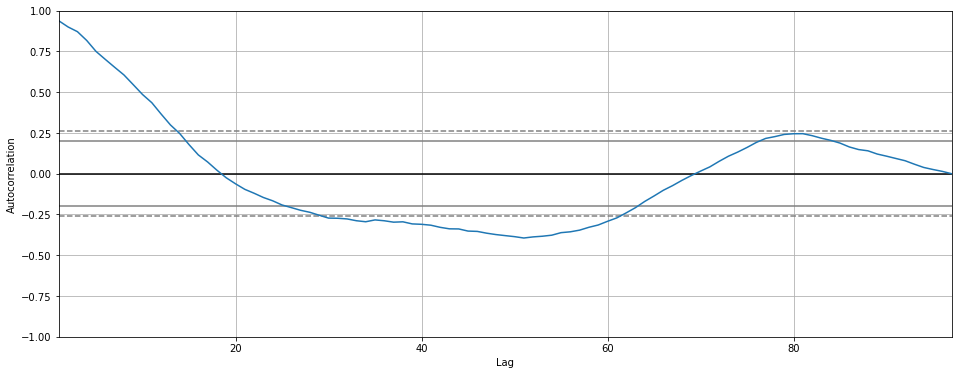

In [ ]:
plt.figure(figsize=(16,6))
pd.plotting.autocorrelation_plot(data[0])

0    -0.544192
1    -0.544192
2    -0.570771
3    -0.491051
4    -0.491051
        ...   
92   -0.570771
93   -0.597342
94   -0.597342
95   -0.623921
96   -0.601379
Name: 0, Length: 97, dtype: float64

In [ ]:
targetDeviceCPU = torch.device('cpu')
targetDeviceGPU = torch.device('cuda:0') 
targetDevice = targetDeviceGPU

# current working 

In [546]:
  extract_df = pd.DataFrame(columns = ['frame', 'stuff'])
  extract_dict = {}
  for i, val in enumerate(npTrainMatrix):
    hour = math.floor((val[1920]*96)/4)
    if hour >= 22:
      hour -= 1
    minute_index = val[1920:1924]
    try:
      minute = (4- np.where(minute_index[:-1] != minute_index[1:])[0][0]-1)
    except: 
      minute = 0
    extract_df = extract_df.append(pd.DataFrame([[timedelta(hours = int(hour), minutes = int(minute*15)), val[:1536]]], columns=['frame','stuff']))

  testing_test = pd.DataFrame(columns = ['index','frame', 'stuff'])
  for i, val in enumerate(test_data):
    hour = math.floor((val[1920]*96)/4)
    if hour >= 22:
      hour -= 1
    minute_index = val[1920:1924]
    try:
      minute = (4- np.where(minute_index[:-1] != minute_index[1:])[0][0]-1)
    except: 
      minute = 0
    testing_test = testing_test.append(pd.DataFrame([[i,timedelta(hours = int(hour), minutes = int(minute*15)), val[:1536]]], columns=['index','frame','stuff']))

In [ ]:
def create_dataset(df):

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in df]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(targetDevice)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(targetDevice)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(targetDevice)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(targetDevice)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(targetDevice)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [654]:
def model_many(hour, minute, extract_df, testing_test):
  anaomaly_list = {}
  for k in range(4):
    for j in range(4):
      RANDOM_SEED = 42
      train_df, val_df = train_test_split(
        np.array([ i.tolist() for i in extract_df[extract_df['frame'] == timedelta(hours = hour, minutes = minute*15)]['stuff']])[:,((j + k*4)*96):(((j+1) + k*4)*96)],
        test_size=0.15,
        random_state=RANDOM_SEED
      )
      
      train_dataset, seq_len, n_features = create_dataset(train_df)
      val_dataset, _, _ = create_dataset(val_df)
      
      test_normal_dataset, _, _ = create_dataset(np.array([ i.tolist() for i in testing_test[testing_test['frame'] == timedelta(hours = hour, minutes = minute*15)]['stuff']])[:,((j + k*4)*96):(((j+1) + k*4)*96)])
      test_index = testing_test[testing_test['frame'] == timedelta(hours = hour, minutes = minute*15)].reset_index(drop = True)['index']

      model = RecurrentAutoencoder(seq_len, n_features, 128)
      model = model.to(targetDevice)

      model, history = train_model(model, 
                                  train_dataset, 
                                  val_dataset, 
                                  n_epochs=40
                                  )
      

      predictions, pred_losses = predict(model, test_normal_dataset)
      sns.distplot(pred_losses, bins=50, kde=True);


      for i,val in enumerate(pred_losses):
        if val > 75:
          diff_mean = test_normal_dataset[i].mean() - predictions[i].mean()
          data = test_normal_dataset[i] - diff_mean
          predictions_new, pred_losses_new = predict(model, [data])
          if pred_losses_new[0] >75:
            plt.figure(
                figsize=(10, 5)
              )
            plt.plot(data, label='true')
            plt.plot(predictions_new[0], label='reconstructed')
            plt.title(f' (loss: {np.around(pred_losses_new[0], 2)})')
            if test_index[i] in anaomaly_list.keys():
              anaomaly_list[test_index[i]].append('{}{}'.format(k,j))
            else:
              anaomaly_list[test_index[i]] = ['{}{}'.format(k,j)]
    print(anaomaly_list)
    print([[k,v] for k,v in anaomaly_list.items() if len(v) <2])

In [ ]:
model_many(0,2,extract_df, testing_test)

Epoch 1: train loss 67.1641269380396 val loss 65.25745725631714
Epoch 2: train loss 65.94536041129719 val loss 64.02668380737305
Epoch 3: train loss 67.08221803470092 val loss 67.05848747491837
Epoch 4: train loss 65.81518427892165 val loss 59.33692413568497
Epoch 5: train loss 65.9651785492897 val loss 62.061917781829834
Epoch 6: train loss 61.64971097491004 val loss 60.62970048189163
Epoch 7: train loss 54.585078011859544 val loss 52.052629351615906
Epoch 8: train loss 52.717798135497354 val loss 51.8668110370636
Epoch 9: train loss 51.892453778873794 val loss 51.84854245185852
Epoch 10: train loss 51.372699065641925 val loss 52.17859536409378
Epoch 11: train loss 51.220919316465206 val loss 52.013679802417755
Epoch 12: train loss 50.57200520688837 val loss 50.74243026971817
Epoch 13: train loss 47.4693325324492 val loss 44.72034001350403
Epoch 14: train loss 44.592606056820266 val loss 54.46994203329086
Epoch 15: train loss 43.716492078521036 val loss 49.71055227518082
Epoch 16: tra

END

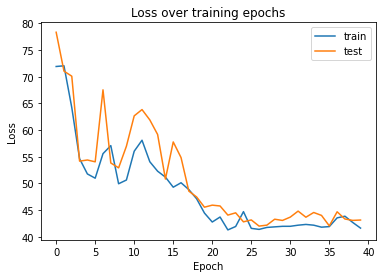

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(targetDevice)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(targetDevice)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [ ]:
import seaborn as sns

In [ ]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

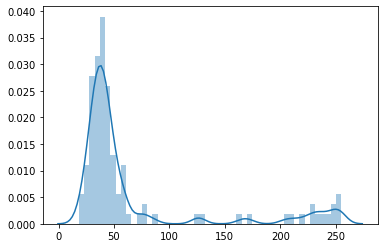

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

fig2, ax2 = plt.subplots(
  nrows=10,
  ncols=1,
  sharey=True,
  sharex=True,
  figsize=(22, 50)
)
count = 1
for i,val in enumerate(pred_losses):
  if val > 75:
    diff_mean = test_normal_dataset[i].mean() - predictions[i].mean()
    data = test_normal_dataset[i] - diff_mean
    predictions_new, pred_losses_new = predict(model, [data])
    if pred_losses_new[0] >75:
      ax2[count].plot(data, label='true')
      ax2[count].plot(predictions_new[0], label='reconstructed')
      ax2[count].set_title(f' (loss: {np.around(pred_losses_new[0], 2)})')
      count +=1

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

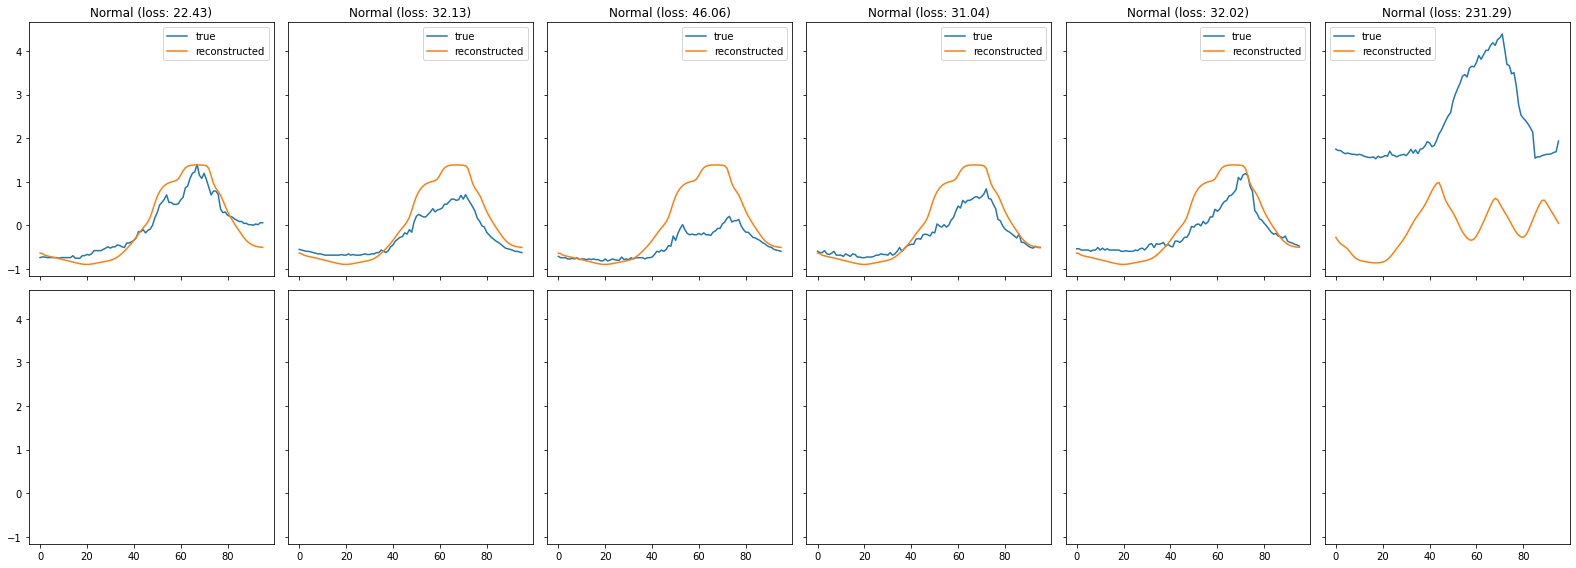

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[6:12]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])


fig.tight_layout();

In [ ]:
predictions, pred_losses = predict(model, [test_data])

In [ ]:
predictions[0].mean()

-0.0021349152

In [ ]:
c

In [ ]:
test_pred = predictions[0] + 2.35
test_data = data - 2.35

In [ ]:
data.mean()

tensor(2.3565)

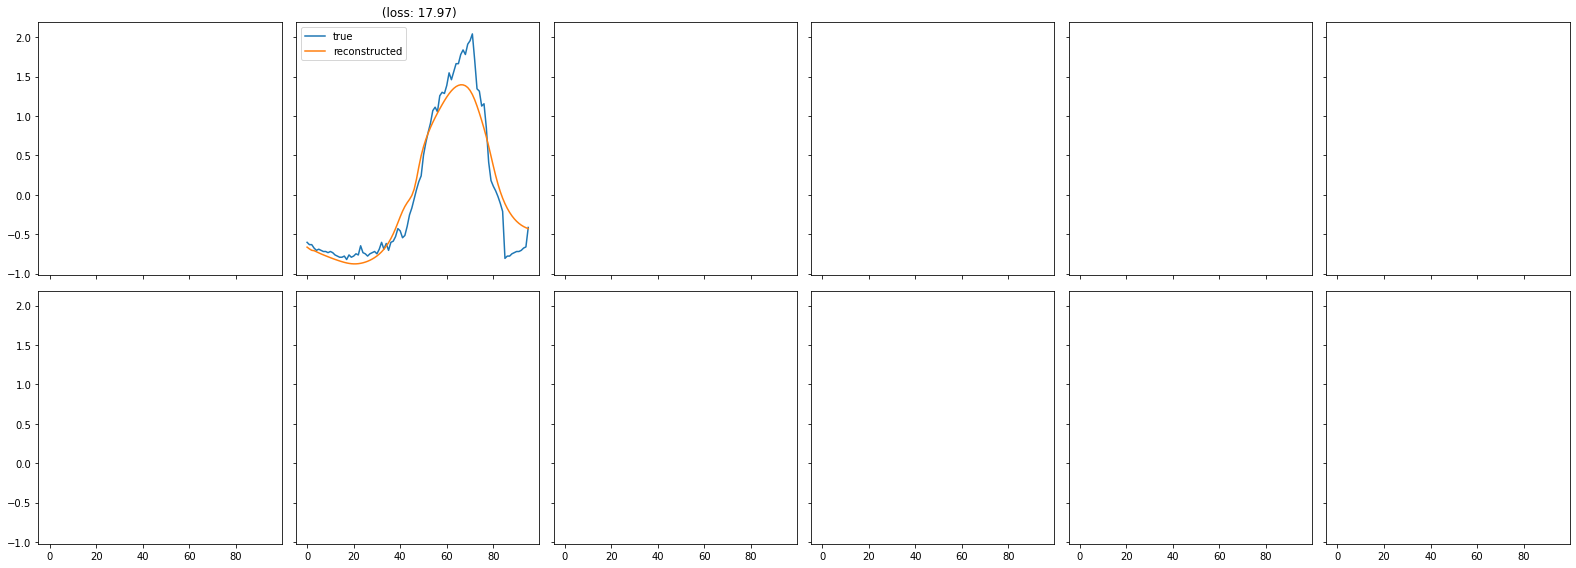

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

axs[0, 1].plot(test_data, label='true')
axs[0, 1].plot(predictions[0], label='reconstructed')
axs[0, 1].set_title(f' (loss: {np.around(pred_losses[0], 2)})')
axs[0, 1].legend()

fig.tight_layout();

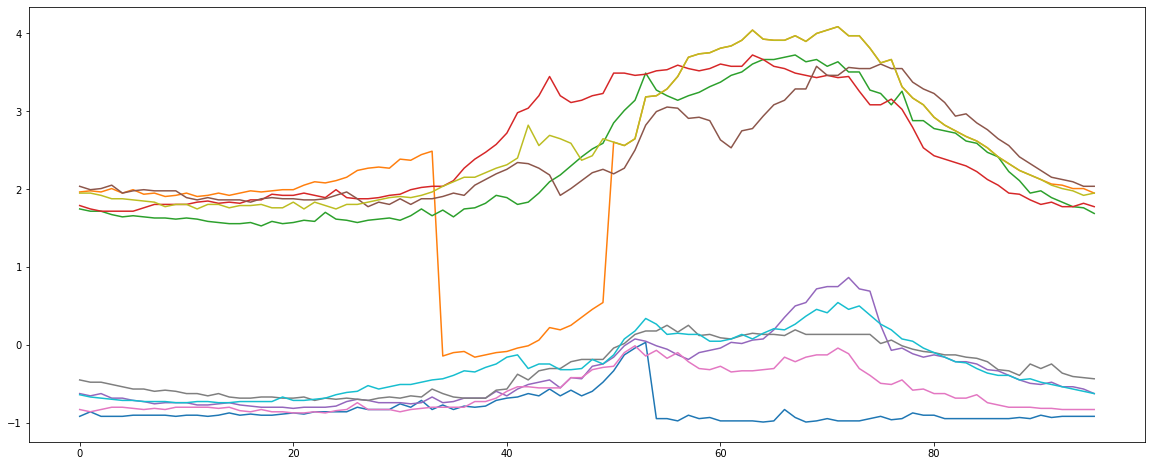

In [ ]:
plt.figure(figsize=(20,8))
for i, data in enumerate(test_normal_dataset[190:200]):
  plt.plot(data)

In [ ]:
def evaluate_model ( model, dataLoader, targetDevice, nEvals = 10):

    for iSample in range(nEvals):

        sample = iter(dataLoader).next()[0] # get first element from sample batch        
        reconstruction = model.forward(sample.to(targetDevice))

        sampleNumpy = sample.numpy()
        reconstructionNumpy = reconstruction.data.cpu().numpy()
        error = np.sqrt( (reconstructionNumpy - sampleNumpy)**2 )

        plt.figure(figsize=(9,5))
        ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
        ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)    

        ax1.plot(sampleNumpy)
        ax1.plot(reconstructionNumpy, '-.')
        ax1.set_title('sample {}, total error {}'.format(iSample, np.sum(error)))
        ax1.legend(['input data', 'reconstruction'])

        ax2.plot(error)
        ax2.legend( ['reconstruction error'] )

In [ ]:
dataLoaderTest = DataLoader( test_normal_dataset, 
                             batch_size = 1, 
                             shuffle = False )

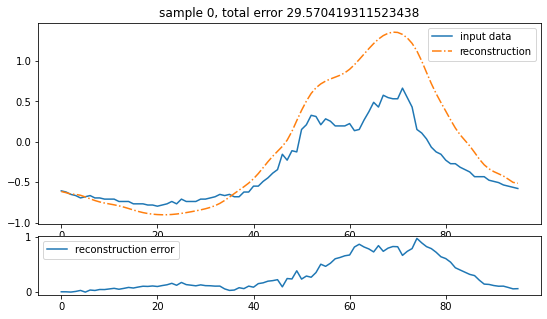

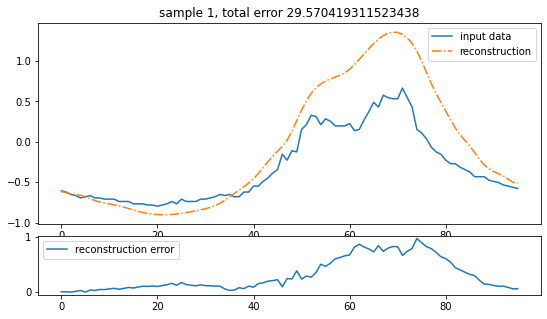

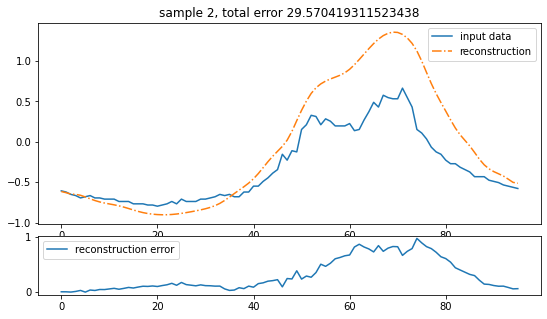

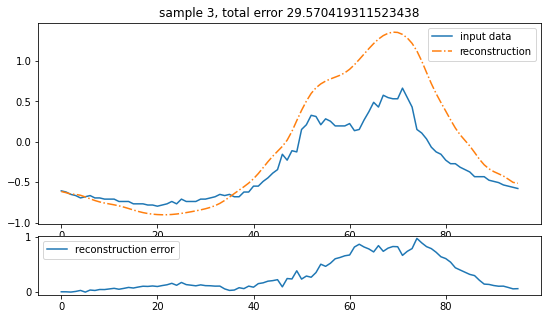

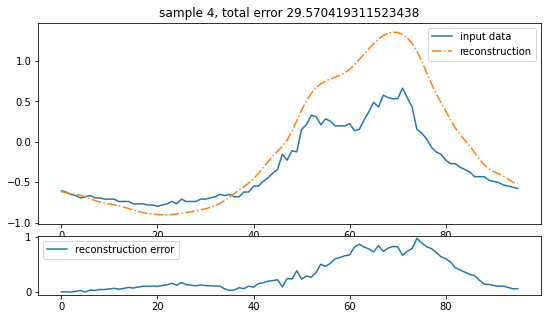

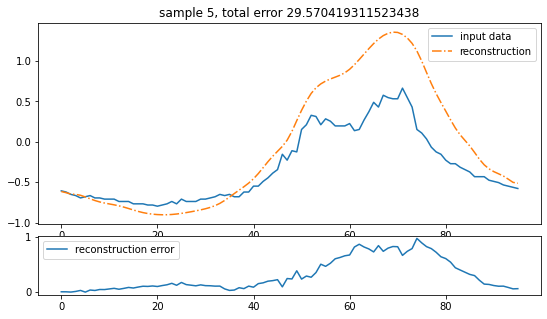

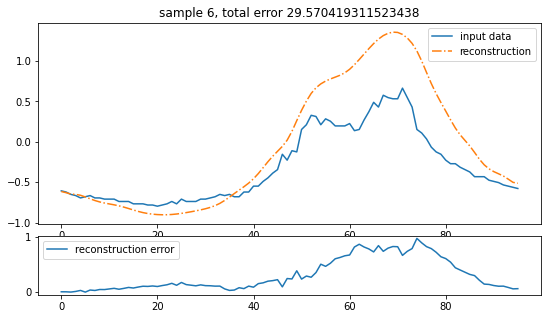

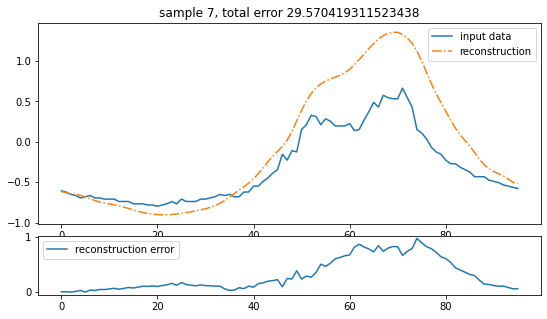

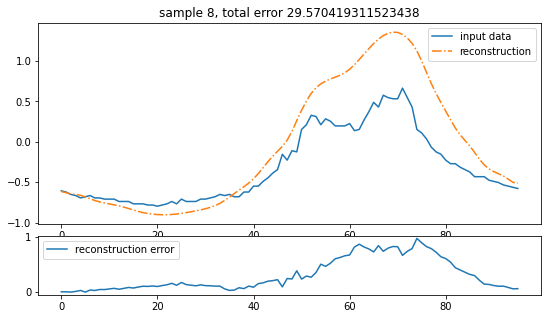

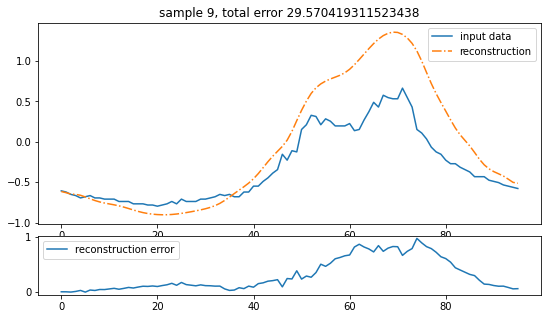

In [ ]:
evaluate_model( model, dataLoaderTest, targetDeviceGPU)